## Import libraries

In [14]:
import warnings
warnings.filterwarnings('ignore')

# Import functions and reload the module after making changes
from scripts import utilities
import importlib
importlib.reload(utilities)
from scripts.utilities import read_shapefile, check_transform_crs, to_geodataframe, transform_raster_crs


#General libraries
import pandas as pd
import geopandas as gdp


#Raster
from osgeo import gdal, osr


#Plotting
import matplotlib.pyplot as plt
from ipywidgets import interact

## Basic exploration of datasets
In this initial notebook, I am focusing exclusively on the data cleaning and transformation processes essential for setting up a robust dataset for the mineral exploration dashboard, specifically targeting rare earth elements (REEs). The objective is to prepare the geological data with precision, ensuring that all further analyses are built on a reliable foundation.

For raster data, I will adjust the resolution to 250 meters to align with my analysis scale and transform all data into the EPSG:4269 Coordinate Reference System (CRS). This CRS selection and resolution adjustment are vital for maintaining accurate spatial relationships across the dataset. To ensure the data's cleanliness and uniformity, I will undertake thorough data cleaning and normalization—removing duplicates, correcting errors, and standardizing formats. Additionally, spatial interpolation techniques will be employed to estimate values for locations not directly sampled, based on the spatial correlation of measured points, filling in any gaps in the data.


### Shapefiles
#### Critical Minerales occurrences across Canada [1]

In [3]:
path = "datasets\shp\critical_minerals.shp"
CM = read_shapefile(path)
CM=check_transform_crs(CM)
CM.head(2)

Shapefile loaded with 270 records
Columns: 21
Geometry type: ['Point']
Transforming from EPSG:3978 to EPSG:4269.


,OBJECTID,OperationG,Operatio_1,PropertyNa,Property_1,OperatorOw,Operator_1,ProvincesE,ProvincesF,Commoditie,...,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
0,1,Mine,Mine,LaRonde,LaRonde,Agnico Eagle Mines Limited,Mines Agnico Eagle Limitée,Quebec,Québec,"Gold, zinc, copper, silver, cadmium",...,Mine,Mine,Active,En activité,48.2516,-78.428,https://agnicoeagle.com,1,None,POINT (-78.42800 48.25160)
1,2,Mine,Mine,Mount Brussilof,Mount Brussilof,Baymag Inc.,Baymag Inc.,British Columbia,Colombie-Britannique,"Magnesite (fused), magnesia (products)",...,Mine,Mine,Active,En activité,50.7887,-115.683,https://baymag.com,2,None,POINT (-115.68300 50.78870)


### Admin boundaries

In [30]:
path2 = r'datasets\shp\admin_boundaries.shp'
admin = read_shapefile(path2)

Shapefile loaded with 13 records
Columns: 7
Geometry type: ['MultiPolygon' 'Polygon']


<Axes: >

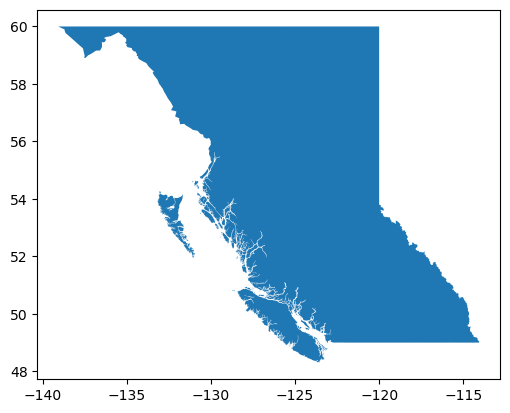

In [31]:
# target_province=admin[admin['PRENAME'].isin(['British Columbia','Nunavut','Ontario','Quebec','Yukon'])]
target_province=admin[admin['PRENAME'].isin(['British Columbia'])]#,'Ontario','Quebec'])]
target_province.plot()

### Geoquem

Esperare a ver que dicen el paper sobre cual es la forma de explorar CM en sedimentos, son >65K muestras es inviable ahora.

In [34]:
# geoquem=pd.read_excel(r'datasets\rgs2020_data.xlsx')
# geoquem.head(2)

,MASTERID,ORIGINAL_REP,UPDATE_REP1,UPDATE_REP2,UPDATE_REP3,NAME,TYPE2,MAP250,MAP50,MAP20,...,W_INA_PPM,Yb_INA_PPM,Zn_INA_PPM,Zr_INA_PPM,WT_INA_g,pH,Uw_LIF_PPB,Fw_ISE_PPB,SO4_TRB_PPM,Cnd_uS/cm
0,ID082E091379,GBC 2010-13,NaN,NaN,NaN,QUEST SOUTH,STRM,082E,082E13,082E.091,...,-1.0,-2.0,NaN,220.0,44.58,7.80,NaN,19.0,NaN,17.0
1,ID082E091380,GBC 2010-13,NaN,NaN,NaN,QUEST SOUTH,STRM,082E,082E13,082E.091,...,-1.0,-2.0,NaN,-200.0,39.18,7.58,NaN,19.0,NaN,18.0


<Axes: >

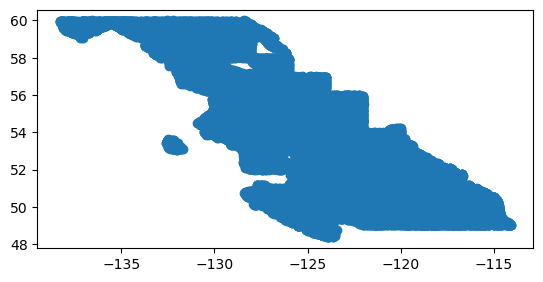

In [57]:
# ## Converting into GeoDataframe
# from shapely.geometry import Point
# geometry = [Point(xy) for xy in zip(geoquem['LONG'], geoquem['LAT'])]
# geoquem_geo = gdp.GeoDataFrame(geoquem, geometry=geometry)
# geoquem_geo.set_crs(epsg=4326, inplace=True)

#### Filtered data

In [60]:
# target_geoquem = geoquem_geo[geoquem_geo.within(target_province.unary_union)]
# # target_geoquem.plot()

## British Columbia

In [85]:
bc= read_shapefile('datasets\shp\BC_bedrock_ll83.shp')
bc=check_transform_crs(bc)

Shapefile loaded with 35424 records
Columns: 28
Geometry type: ['Polygon']
CRS is already correct.


#### Geochronology

In [86]:
new=to_geodataframe(r'datasets\BCGS_GF2020-10\BCGS_GF2020-10\new_age.csv','WGS84-lat','WGS84-long')
# NOTE: The "Sample age" field is not numeric. Six values are ranges such as "170-180".
# It might be useful to either convert these values into a numeric format or exclude them in later steps.


Error reading the file with utf-8. Trying with 'latin1' encoding...
GeoDataFrame created with 532 records
Geometry type: ['Point']
CRS=EPSG:4269


Simplyfing map by rock_class  + CM within BC province

In [87]:
bc_rocks=bc.dissolve(by='rock_class')
bc_rocks.reset_index(inplace=True) 
#Intersect CM points with BC polygons
bc_cm=gdp.sjoin(CM,bc_rocks, how='inner', op='within')

### Interactivce map

In [73]:
##Interactive map targeting CM column 
column1_values = bc_cm['Developmen'].unique()
# column2_values = bc_cm['Developmen'].unique()

@interact(column1=column1_values)
def show_map(column1):

    fig, ax = plt.subplots(figsize=(10,10))
    
    #Rock type
    bc_rocks.plot(ax=ax, column='rock_class', legend=True, cmap='viridis')
    
    #Geocronology
    new.plot(ax=ax, color ='black', marker ='o', markersize=7, alpha=0.6)
    # Adding labels for geochronology points
    # for x, y, label in zip(new.geometry.x, new.geometry.y, new['Sample Age']):
    #     ax.text(x, y, label, fontsize=8, ha='right', color='black')

    #Filtering by value for interactive map
    data_filtered = bc_cm[bc_cm['Developmen'] == column1]
    data_filtered.plot(ax=ax, color='red', marker='o', markersize=7)

    ## Adding Wicheeda point of interest
    wicheeda = bc_cm[bc_cm['Commoditie']=='Rare earth elements']
    x = wicheeda.geometry.x.iloc[0]
    y = wicheeda.geometry.y.iloc[0]
    ax.scatter(x,y, color='white', marker='o', s=50)
    ax.text(x,y,'wich', fontsize=7, ha='left', color ='white')
   

    plt.title('BC simplyfied map by rock class')
    plt.show()

interactive(children=(Dropdown(description='column1', options=('Mine', 'Smelter', 'Smelter, refinery, plant', …

In [25]:
# bc_cm['Commoditie'] = bc_cm['Commoditie'].str.strip()
bc_cm[bc_cm['Commoditie']=='Rare earth elements'].values.flatten()


array([264, 'Project', 'Projet', 'Wicheeda', 'Wicheeda',
       'Defense Metals Corp.', 'Defense Metals Corp.', 'British Columbia',
       'Colombie-Britannique', 'Rare earth elements',
       'Éléments des terres rares', 'Advanced project', 'Projet avancé',
       'Active', 'En activité', 54.53141, -122.09912,
       'https://defensemetals.com', '264', None, <POINT (-122 54.5)>, 5,
       'sedimentary rocks', 32899, '3a407beb', 26984024.0, 'DPBC',
       'Paleozoic', 'Devonian to Permian', 'Upper Devonian to Permian',
       'Big Creek Group', 'Big Creek Group',
       'Yanks Peak, Midas, Mural and Dome Creek Formations',
       'Snippaker unit',
       'mudstone, siltstone, shale fine clastic sedimentary rocks',
       'siliceous',
       'Shale, argillite, slate, calcareous argillite, limestone, tuffaceous argillite, sandstone, wacke, dacite, tuffaceous dacite; equivalent to the Earn Group',
       'Upper Devonian', 'Permian', 'Omineca', 'Cassiar',
       'Whitehorse Trough', 'Lower

In [18]:

print([f'{col}: {len(bc_cm[col].unique())}' for col in bc_cm.columns])

['OBJECTID: 44', 'OperationG: 3', 'Operatio_1: 3', 'PropertyNa: 44', 'Property_1: 44', 'OperatorOw: 34', 'Operator_1: 34', 'ProvincesE: 1', 'ProvincesF: 1', 'Commoditie: 32', 'Commodit_1: 31', 'Developmen: 5', 'Developm_1: 5', 'ActivitySt: 2', 'Activity_1: 2', 'Latitude: 44', 'Longitude: 44', 'Website: 37', 'ID: 44', 'EA_Status: 1', 'geometry: 44', 'index_right: 5', 'rock_class: 5', 'gid: 5', 'upid: 5', 'area_m2: 5', 'strat_unit: 4', 'era: 3', 'period: 4', 'strat_age: 5', 'strat_name: 4', 'gp_suite: 4', 'fm_lithodm: 5', 'mem_phase: 5', 'rock_type: 4', 'rk_char: 5', 'unit_desc: 4', 'age_max: 5', 'age_min: 5', 'belt: 2', 'terrane: 3', 'basin: 3', 'basin_age: 3', 'project: 2', 'src_url: 2', 'src_ref_s: 2', 'map_comp: 2', 'edit_date: 1', 'pub_org: 1']


In [44]:
bc_cm[bc_cm['Commoditie']=='Rare earth elements'].iloc[:, 40:]
# len(bc_cm[bc_cm['Commoditie']=='Rare earth elements'].columns)

,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org
263,Cassiar,Whitehorse Trough,Lower Jurassic,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey


In [75]:
CM[CM['Commoditie']=='Rare earth elements'].iloc[:,7:18]

,ProvincesE,ProvincesF,Commoditie,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website
144,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca
163,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com
199,Northwest Territories,Territoires du Nord-Ouest,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,62.118060,-112.599720,https://vitalmetals.com.au
214,Newfoundland and Labrador,Terre-Neuve-et-Labrador,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,52.398330,-55.824170,Not available/Pas disponible
223,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,Active,En activité,52.140033,-106.627370,https://www.src.sk.ca/campaigns/rare-earth-pro...
224,Ontario,Ontario,Rare earth elements,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/
227,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca
230,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,On hold / suspended,En attente / suspendu,52.176809,-106.656706,https://vitalmetals.com.au
232,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com
263,British Columbia,Colombie-Britannique,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,54.531410,-122.099120,https://defensemetals.com


In [4]:
CM[(CM['Commoditie']=='Rare earth elements') & (CM['ProvincesE'].isin(['Quebec','Ontario']))].iloc[:,10:]

,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
144,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca,145,None,POINT (-78.47450 46.81747)
163,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com,164,None,POINT (-68.40417 56.94583)
224,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/,225,None,POINT (-76.50000 44.23333)
227,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca,228,None,POINT (-73.34081 45.52598)
232,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com,233,None,POINT (-71.15445 48.54277)


In [82]:
palabras_clave = 'Canyon Creek'

# Crear una máscara que identifica si las palabras clave están presentes en alguna celda
mask = CM.applymap(lambda x: palabras_clave in str(x))

# Verificar si hay coincidencias en alguna parte del DataFrame
if mask.any().any():
    # Mostrar las filas donde aparecen las palabras clave
    filas_coincidentes = CM[mask.any(axis=1)]
    print(filas_coincidentes)
else:
    print("No se encontraron coincidencias con las palabras clave.")

No se encontraron coincidencias con las palabras clave.


### Rasters
#### Magnetic Total Field

In [1]:
ruta_archivo = r'datasets\raster\Canada_200m_MAG\Canada - 200m - First Vertical Derivative of the Magnetic Field - 2024 - March - Geotiff.TIF'
dataset = gdal.Open(ruta_archivo)
banda = dataset.GetRasterBand(1)
datos = banda.ReadAsArray()


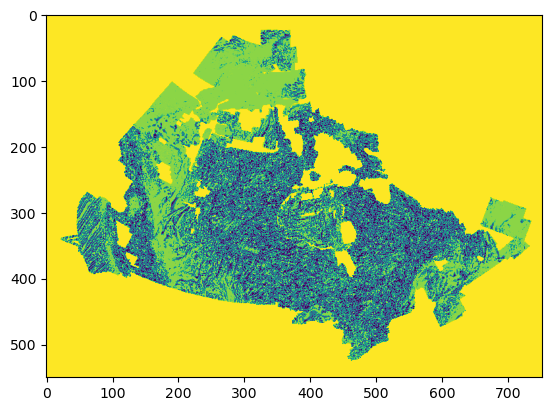

In [4]:
plt.figure()
plt.imshow(datos)

In [11]:
dataset.GetGeoTransform

<bound method Dataset.GetGeoTransform of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000227D2F68C60> >>

In [118]:
datos=None

In [13]:
wkt = dataset.GetProjection()
#Crear un objeto SpatialReference
srs = osr.SpatialReference(wkt=wkt)


In [16]:
print("Proyección:", srs.GetAttrValue('PROJCS'))

print("Nombre del sistema de coordenadas:", srs.GetAttrValue('GEOGCS'))

Proyección: NAD83 / Canada Atlas Lambert
Nombre del sistema de coordenadas: NAD83


In [6]:
import rasterio

def check_resolution(file_path):
    with rasterio.open(file_path) as src:
        res_x, res_y = src.res
        print(f"Resolution for {file_path}: {res_x} x {res_y}")

# Lista de tus archivos raster
raster_files = [r'datasets\raster\Canada_200m_MAG\Canada - 200m - First Vertical Derivative of the Magnetic Field - 2024 - March - Geotiff.TIF', r'datasets\raster\Canada_200m_MAG\Canada - 200m - Residual Magnetic Field - 2024 - March - Geotiff.TIF']
for file in raster_files:
    check_resolution(file)

Resolution for datasets\raster\Canada_200m_MAG\Canada - 200m - First Vertical Derivative of the Magnetic Field - 2024 - March - Geotiff.TIF: 8999.999910385162 x 8999.999910385162
Resolution for datasets\raster\Canada_200m_MAG\Canada - 200m - Residual Magnetic Field - 2024 - March - Geotiff.TIF: 8999.999910385162 x 8999.999910385162


In [8]:
import rasterio

def print_metadata(file_path):
    with rasterio.open(file_path) as src:
        print("CRS:", src.crs)
        print("Resolution:", src.res)
        print("Bounds:", src.bounds)
        print("Tags:", src.tags())

print_metadata(r'datasets\raster\Canada_200m_MAG\Canada - 200m - First Vertical Derivative of the Magnetic Field - 2024 - March - Geotiff.TIF')


CRS: EPSG:3978
Resolution: (8999.999910385162, 8999.999910385162)
Bounds: BoundingBox(left=-3145949.999955691, bottom=-998749.9999556895, right=3631049.9325643363, top=3951249.9507561494)
Tags: {'AREA_OR_POINT': 'Area'}


 geojson = [mapping(geometry)]
The mapping function from shapely.geometry converts the geometric object into a GeoJSON-like Python dictionary. GeoJSON is a format for encoding geographic data structures. The mapping function essentially translates the shapely geometry into a format that rasterio can understand and use, specifically for the masking operation. The reason it is wrapped in a list ([mapping(geometry)]) is because the mask function from rasterio expects a list of GeoJSON geometries – this allows for multiple geometries to be used in the masking operation, though only one geometry is being used here.

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import os

def process_and_reproject_rasters(raster_paths, polygon_shapefile, output_directory, target_crs='EPSG:4269'):
    """
    Processes a list of rasters by ensuring they all have the CRS EPSG:4269,
    reprojects if necessary, and crops the rasters using a reference polygon.

    Args:
    raster_paths (list of str): Paths to the raster files.
    polygon_shapefile (str): Path to the shapefile containing the cropping polygon.
    output_directory (str): Directory where the cropped and reprojected rasters will be saved.
    target_crs (str): The target CRS to standardize all rasters (default 'EPSG:4269').
    """
    # Load the cropping polygon
    gdf = gpd.read_file(polygon_shapefile)
    if gdf.crs != target_crs:
        gdf = gdf.to_crs(target_crs)
    
    # Get the polygon as a geometric object
    geometry = gdf.iloc[0].geometry
    geojson = [mapping(geometry)]
    
    for raster_path in raster_paths:
        with rasterio.open(raster_path) as src:
            src_crs = src.crs
            if src_crs != target_crs:
                # Calculate the transformation needed and the new dimensions
                transform, width, height = calculate_default_transform(
                    src.crs, target_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                
                # Reproject the raster
                reprojected_path = f"{output_directory}/reprojected_{os.path.basename(raster_path)}"
                with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=target_crs,
                            resampling=Resampling.nearest)
                raster_path = reprojected_path
            
            # Crop the raster using the polygon
            with rasterio.open(raster_path) as src:
                out_image, out_transform = mask(src, geojson, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
                
                output_path = f"{output_directory}/cropped_{os.path.basename(raster_path)}"
                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)

    print("All rasters processed to CRS EPSG:4269 and cropped as specified.")

# Example of usage
raster_paths = ['path/to/raster1.tif', 'path/to/raster2.tif']
polygon_shapefile = 'path/to/polygon.shp'
output_directory = 'path/to/output'

process_and_reproject_rasters(raster_paths, polygon_shapefile, output_directory)
